<a href="https://colab.research.google.com/github/JunTu-XD/EmbeddingBleu/blob/main/Embedding_Bleu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset
dataframe: df [
ref
sys
mqm
bleu]


In [1]:
import pandas as pd
from google.colab import drive
from io import StringIO
import matplotlib.pyplot as plt
import numpy as np
import torch
seed = 23
torch.manual_seed(seed)
np.random.seed(seed)

drive.mount('/content/drive')
# data = pd.read_csv('/content/drive/MyDrive/CL_ESSENTIALS/mqm_newstest2021_zhen.tsv', sep='\t', quoting = 2)

with open('/content/drive/MyDrive/CL_ESSENTIALS/mqm_newstest2021_zhen.tsv') as f:
  contents = f.read()
  contents = contents.replace("”", '')
  contents = contents.replace('"', '')

data = pd.read_csv(StringIO(contents), sep='\t')
data

Mounted at /content/drive


,system,doc,doc_id,seg_id,rater,source,target,category,severity
0,hyp.Borderline,chinanews.com.229454,1,1644,rater8,当地时间25日下午，一架小型飞机在德国北威州韦瑟尔县撞上一座多层住宅楼的顶层，事故共造成三人死亡。,"On the afternoon of the 25th local time, a sma...",Locale convention/Address format,Major
1,hyp.DIDI-NLP,chinanews.com.229454,1,1644,rater9,当地时间25日下午，一架小型飞机在德国北威州韦瑟尔县撞上一座多层住宅楼的顶层，事故共造成三人死亡。,<v>On</v> the afternoon of the 25th local time...,Fluency/Grammar,Major
2,hyp.DIDI-NLP,chinanews.com.229454,1,1644,rater9,当地时间25日下午，一架小型飞机在德国北威州韦瑟尔县撞上一座多层住宅楼的顶层，事故共造成三人死亡。,"On the afternoon of the 25th local time, a sma...",Accuracy/Addition,Major
3,hyp.Facebook-AI,chinanews.com.229454,1,1644,rater2,当地时间25日下午，一架小型飞机在德国北威州韦瑟尔县撞上一座多层住宅楼的顶层，事故共造成三人死亡。,"On the afternoon of the 25th local time, a sma...",Accuracy/Mistranslation,Minor
4,hyp.IIE-MT,chinanews.com.229454,1,1644,rater3,当地时间25日下午，一架小型飞机在德国北威州韦瑟尔县撞上一座多层住宅楼的顶层，事故共造成三人死亡。,"On the afternoon of the 25th local time, a <v>...",Terminology/Inappropriate for context,Major
...,...,...,...,...,...,...,...,...,...
17216,hyp.metricsystem5,xinhua-zh-01.120586,12,259,rater1,饮食上可选择绿豆、薏仁等具有清热解暑、健脾开胃作用的食物，以及苦菜、苦瓜等苦味食物，可有助于...,Foods that have the effect of clearing heat an...,Style/Awkward,Minor
17217,ref.A,xinhua-zh-01.120586,12,259,rater1,饮食上可选择绿豆、薏仁等具有清热解暑、健脾开胃作用的食物，以及苦菜、苦瓜等苦味食物，可有助于...,"Therefore, mung beans and coix seeds should be...",Accuracy/Mistranslation,Major
17218,ref.B,xinhua-zh-01.120586,12,259,rater2,饮食上可选择绿豆、薏仁等具有清热解暑、健脾开胃作用的食物，以及苦菜、苦瓜等苦味食物，可有助于...,"People may choose mung beans, Job's tears, and...",Accuracy/Mistranslation,Minor
17219,ref.B,xinhua-zh-01.120586,12,259,rater2,饮食上可选择绿豆、薏仁等具有清热解暑、健脾开胃作用的食物，以及苦菜、苦瓜等苦味食物，可有助于...,"People may choose mung beans, Job's tears, and...",Fluency/Punctuation,Minor


One error in a segment is recoreded in one line in the data file. To ccollect all errors associated with the same segment, we have to accumulate them.

We use ref-B as the ground truth because it has a better MQM score.


In [2]:
# Helper functions

def clean_mqm_viewer_annotations(input: str) -> str:
  # Rmove MQM viewer tags
  output = input.replace("<v>", "")
  output = output.replace("</v>", "")
  return output

def mqm_score(category: str, severity: str) -> float:
  if category == severity == "No-error":
    return 0
  
  if category == "Non-translation":
    return 25
  
  if severity == "Minor":
    if category == "Fluency/Punctuation":
      return 0.1
    else:
      return 1
  elif severity == "Major":
    return 5
  else:
    raise Exception(f"Unexpected MQM evaluation severity: {severity}")

In [3]:
# Collect ref-B translations in a hashmap (seg_id -> target)
refs = {}

for i in data.index:
  if data['system'][i] == "ref.B":
    refs[data['seg_id'][i]] = clean_mqm_viewer_annotations(data['target'][i])

len(refs)

650

In [4]:
from nltk.translate.bleu_score import corpus_bleu

# Collect translations from all systems, accumulate their MQM scores, 
# calculate their BLEU scores and match the reference translation
translations = {}

for i in data.index:
  if data['system'][i] == "ref.A" or data['system'][i] == "ref.B":
    # Skip references - we only look for translations
    continue

  if data['seg_id'][i] not in refs:
    # We don't have a reference for this translation
    continue

  ref = refs[data['seg_id'][i]]
  system = clean_mqm_viewer_annotations(data['target'][i])

  key = (data['system'][i], data['seg_id'][i])
  if key not in translations:
    translations[key] = {
        "ref": ref,
        "sys": system,
        "mqm": 0,
        "bleu": 0.0,
    }

    # Calculate BLEU score for ref vs sys
    bleu = corpus_bleu([[ref]], [system])
    translations[key]["bleu"] = bleu

  # Accumulate MQM score for this translation
  mqm = mqm_score(data['category'][i], data['severity'][i])
  translations[key]["mqm"] += mqm

len(translations)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

8450

In [5]:
# Only for Sequence Embedding part

df = pd.DataFrame.from_dict(translations.values())

max_len = len(max(df['ref'], key=len))+1

ref = []
sys = []
bleu_data = []
mqm_data =[]
for i in range(len(df['ref'])):
    if max_len > len(df['ref'][i]) and max_len > len(df['sys'][i]):
        ref.append(df['ref'][i])
        sys.append(df['sys'][i])
        bleu_data.append(df['bleu'][i])
        mqm_data.append(df['mqm'][i])

# assume A is 1d
def normalize(func, A, **args):
    if func == "scaling_range":
        return (torch.tensor(A)- args['range_min']) / (args['range_max']- args['range_min'])

idx = np.random.RandomState(seed=seed).permutation(len(ref))

ref = np.asarray(ref)[idx].tolist()
sys = np.asarray(sys)[idx].tolist()
bleu_data =(np.asarray(bleu_data))[idx].tolist()
mqm_data =np.asarray(mqm_data)[idx].tolist()


mqm_data = torch.tensor(mqm_data)
mqm_data = 25-mqm_data
mqm_data = normalize("scaling_range", mqm_data, range_min=0,range_max=25).tolist()
mqm_data[0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0.0

### Randonly Word Disorder 

In [32]:
## random seq words order

def random_disorder(seqs, labels, cnt,  swap_dist, label_penality, disorder_percentage=0.5):
    np.random.seed(seed)
    rdn_seqs = []
    rdn_labels = []
    for seq_id, seq in enumerate(seqs):
        lst = seq.split(" ")
        rdn_if = np.random.uniform(0,1)
        if (len(lst)<=swap_dist or rdn_if > disorder_percentage):
            # print(seq_id)
            # print(seq)
            rdn_labels.append(labels[seq_id])            
            rdn_seqs.append(seq)
            continue
        for i in range(cnt):
            indx = np.random.randint(0, len(lst)-swap_dist)
            lst[indx], lst[swap_dist+indx] = lst[swap_dist+indx], lst[indx]

        rdn_labels.append(labels[seq_id]-label_penality)
        rdn_seqs.append(' '.join(lst))

        rdn_labels.append(labels[seq_id])
    
        rdn_seqs.append(seq)
        
    return rdn_seqs,rdn_labels
def random_disorder_seq(seq, label, cnt,  swap_dist, label_penality, disorder_percentage=0.5):
    lst = seq.split(" ")
    rdn_if = np.random.uniform(0,1)
    if (len(lst)<=swap_dist or rdn_if > disorder_percentage):
        # print(seq_id)
        # print(seq)
        return seq, label
    
    indx = np.random.randint(0, len(lst)-swap_dist)
    lst[indx], lst[swap_dist+indx] = lst[swap_dist+indx], lst[indx]

    
    return ' '.join(lst), label-label_penality
random_disorder(sys[35:38], mqm_data[35:38], cnt=3, swap_dist=1, label_penality=0.04, disorder_percentage=0)


(['(Reporter Nie Qing)',
  'The Ministry of Commerce of China issued a press release on this issue on the evening of the 23rd, stating that China implements a managed floating exchange rate system based on market supply and demand and adjusted by reference to a basket of currencies, and that the market plays a decisive role in the formation of the exchange rate.',
  'Fauci said that some regions in the United States are currently struggling to fight the rebounding epidemic.'],
 [1.0, 0.9599999785423279, 1.0])

### distribution of MQM score

Text(0.5, 1.0, 'MQM data distribution')

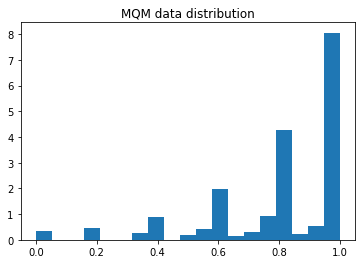

In [7]:
plt.figure("11")
plt.hist(mqm_data, bins=np.linspace(0,1, 20), density=True)
plt.title("MQM data distribution")

## Word Embedding

In [8]:
import numpy as np

# Normalize MQM scores (0-25 -> 0-1)
df['mqm'] = 1 - (df['mqm'] / 25)
df

,ref,sys,mqm,bleu
0,"On the afternoon of 25th local time, a small p...","On the afternoon of the 25th local time, a sma...",0.80,0.869641
1,"On the afternoon of 25th local time, a small p...","On the afternoon of the 25th local time, a sma...",0.60,0.827809
2,"On the afternoon of 25th local time, a small p...","On the afternoon of the 25th local time, a sma...",0.96,0.808414
3,"On the afternoon of 25th local time, a small p...","On the afternoon of the 25th local time, a sma...",0.40,0.797764
4,"On the afternoon of 25th local time, a small p...","On the afternoon of the 25th local time, a sma...",0.80,0.848011
...,...,...,...,...
8445,"People may choose mung beans, Job's tears, and...","In the diet, you can choose foods such as mung...",1.00,0.593262
8446,"People may choose mung beans, Job's tears, and...","In the diet, you can choose mung beans, barley...",0.60,0.625317
8447,"People may choose mung beans, Job's tears, and...","In the diet, you can choose foods such as mung...",0.36,0.600479
8448,"People may choose mung beans, Job's tears, and...","Dietary choice of mung beans, barley and other...",0.92,0.476085


In [9]:
# Drop rows where MQM score is exactly 0
df = df[df["mqm"] != 0]
df

,ref,sys,mqm,bleu
0,"On the afternoon of 25th local time, a small p...","On the afternoon of the 25th local time, a sma...",0.80,0.869641
1,"On the afternoon of 25th local time, a small p...","On the afternoon of the 25th local time, a sma...",0.60,0.827809
2,"On the afternoon of 25th local time, a small p...","On the afternoon of the 25th local time, a sma...",0.96,0.808414
3,"On the afternoon of 25th local time, a small p...","On the afternoon of the 25th local time, a sma...",0.40,0.797764
4,"On the afternoon of 25th local time, a small p...","On the afternoon of the 25th local time, a sma...",0.80,0.848011
...,...,...,...,...
8445,"People may choose mung beans, Job's tears, and...","In the diet, you can choose foods such as mung...",1.00,0.593262
8446,"People may choose mung beans, Job's tears, and...","In the diet, you can choose mung beans, barley...",0.60,0.625317
8447,"People may choose mung beans, Job's tears, and...","In the diet, you can choose foods such as mung...",0.36,0.600479
8448,"People may choose mung beans, Job's tears, and...","Dietary choice of mung beans, barley and other...",0.92,0.476085


In [10]:
import spacy
spacy.cli.download("en_core_web_md")
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [11]:
nlp = spacy.load('en_core_web_lg')

In [12]:
from scipy import spatial

# Implementing the similarity function
def similarity(sys: str, ref: str) -> float:
  doc_sys = nlp(sys)
  doc_ref = nlp(ref)

  # Length penalty will reduce the overall score if the difference between the 
  # lengths of the references and the system output is large.
  longer = max(len(doc_ref), len(doc_sys))
  shorter = min(len(doc_ref), len(doc_sys))
  length_penalty = np.exp(1 - (longer / shorter))

  # Find a closest word for every token in the system output
  similarities = []
  for sys_token in doc_sys:
    max_similarity = 0
    for ref_token in doc_ref:
      similarity = 1 - spatial.distance.cosine(sys_token.vector, ref_token.vector)
      if similarity > max_similarity:
        max_similarity = similarity
    similarities.append(max_similarity)

  score = length_penalty * np.mean(similarities)
  
  return score

In [13]:
a = "There is a gun in the gum"
b = "There is a rifle inside of the gum"
score = similarity(a, b)
bleu = corpus_bleu([[a]], [b])

score, bleu

longer = 50
shorter = 45
np.exp(1 - (longer / shorter))

0.8948393168143697

In [38]:
# Calculate our custom scores for the data
scores = []
for i in df.index:
  score = similarity(df['sys'][i], df['ref'][i])
  scores.append(score)

df["score"] = scores
df

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,ref,sys,mqm,bleu,score
0,"On the afternoon of 25th local time, a small p...","On the afternoon of the 25th local time, a sma...",0.80,0.869641,0.917237
1,"On the afternoon of 25th local time, a small p...","On the afternoon of the 25th local time, a sma...",0.60,0.827809,0.875432
2,"On the afternoon of 25th local time, a small p...","On the afternoon of the 25th local time, a sma...",0.96,0.808414,0.934564
3,"On the afternoon of 25th local time, a small p...","On the afternoon of the 25th local time, a sma...",0.40,0.797764,0.902009
4,"On the afternoon of 25th local time, a small p...","On the afternoon of the 25th local time, a sma...",0.80,0.848011,0.900179
...,...,...,...,...,...
8445,"People may choose mung beans, Job's tears, and...","In the diet, you can choose foods such as mung...",1.00,0.593262,0.962967
8446,"People may choose mung beans, Job's tears, and...","In the diet, you can choose mung beans, barley...",0.60,0.625317,0.981652
8447,"People may choose mung beans, Job's tears, and...","In the diet, you can choose foods such as mung...",0.36,0.600479,1.000000
8448,"People may choose mung beans, Job's tears, and...","Dietary choice of mung beans, barley and other...",0.92,0.476085,0.687289


In [ ]:
df['bleu_error'] = np.absolute(df["mqm"] - df["bleu"])
df['score_error'] = np.absolute(df["mqm"] - df["score"])

In [ ]:
df["bleu_error"].plot(kind="hist", bins=100, grid=True)

In [ ]:
df["score_error"].plot(kind="hist", bins=100, grid=True)

In [ ]:
print(f"BLEU error mean, error variance: {df['bleu_error'].mean()}, {df['bleu_error'].var()}, {df['bleu_error'].std()}")
print(f"Score error mean, error variance: {df['score_error'].mean()}, {df['score_error'].var()}, {df['score_error'].std()}")

In [ ]:
df_sorted = df.sort_values("score_error")
with pd.option_context('display.max_colwidth', None,
                       'display.max_columns', None,
                       'display.max_rows', None):
    display(df_sorted)
# df[df["mqm"] != 0]

# data["category"].unique(), data["severity"].unique()

## Sequence Embedding
https://www.sbert.net/examples/applications/computing-embeddings/README.html

Ref:https://arxiv.org/abs/1908.10084


In [15]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.2 MB/s 
     |████████████████████████████████| 4.9 MB 16.4 MB/s 
     |████████████████████████████████| 1.3 MB 68.2 MB/s 
     |████████████████████████████████| 120 kB 15.4 MB/s 
     |████████████████████████████████| 6.6 MB 63.1 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=339e52e29a3d59df0bf63a383089a9c76e814612fc8f4dcd36937d134854b1a3
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [16]:
from sentence_transformers import SentenceTransformer, util
import pickle
import torch

seq_pretrained_model = SentenceTransformer('all-mpnet-base-v2')

seq_pretrained_model.max_seq_length = max_len

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [17]:
# embedding vector shape (768,)
def seq_embeddings(seq_model , sentences):
    embeddings = seq_model.encode(sentences, convert_to_tensor=True)
    return (sentences, embeddings)

def save_seq_embedding(embeddings, path="./"):
    with open(f'{path}embeddings.pkl', "wb") as fOut:
        pickle.dump({'sentences': sentences, 'embeddings': embeddings}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

def load_seq_embeddings(path="./"):
    #Load sentences & embeddings from disc
    embedding = []
    with open(f'{path}embeddings.pkl', "rb") as fIn:
        stored_data = pickle.load(fIn)
        stored_sentences = stored_data['sentences']
        stored_embeddings = stored_data['embeddings']
        return stored_sentences,stored_embeddings
## test code
sentences = ["a gun is harmful", "there is a gum in a gun", "A handgun is over there"]
_, embdeddings = seq_embeddings(seq_pretrained_model,sentences)

save_seq_embedding(embdeddings)

_, embeddings = load_seq_embeddings()

cosine_scores = util.cos_sim(embeddings, embeddings)
cosine_scores

tensor([[1.0000, 0.4552, 0.4997],
        [0.4552, 1.0000, 0.5246],
        [0.4997, 0.5246, 1.0000]], device='cuda:0')

## Experiments

#### Error Metrics


In [18]:
# input A, target B
def error_wrapper(func, A, B):
    if func=="square_loss":
       return (torch.tensor(A)-torch.tensor(B))**2
    if function=="abs":
        return torch.abs(torch.tensor(A)-torch.tensor(B))
    return 

    
def data_transform(df, col_name):
    col_list = df[col_name].tolist()
    return col_list

In [19]:
# assume 1d input
def sum_up_errors(A_error, B_error):
    return (torch.count_nonzero(torch.tensor(A_error) < torch.tensor(B_error)) / len(A_error))
    
# return [nx1] as pairwise similarity
def similarity_wrapper(func, As, Bs):
    similarity_matrix = []
    if func == "cosine":
        similarity_matrix = util.cos_sim(As, Bs)
    else:
        # default
        similarity_matrix = util.cos_sim(As, Bs) 
    return torch.diagonal(similarity_matrix)

### Training

In [20]:
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from torch.utils.data import DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
train_num = int(len(ref)*0.8)
val_num = int(len(ref)*0.05)
# model_name, , 
# disorder_percentage, disorder_cnt, disorder_swap_dist, label_penality
def train_model(**args):
    global device
    seq_trained_model = SentenceTransformer('all-mpnet-base-v2', device=device)
    seq_trained_model.max_seq_length = max_len

    global train_num, val_num

    disorder_sys,disorder_mqm = random_disorder(sys[0:train_num], mqm_data[0:train_num], 
                                                cnt=args['disorder_cnt'], swap_dist=args['disorder_swap_dist'], label_penality=args['label_penality'], disorder_percentage=args['disorder_percentage'])

    train_samples = [InputExample(texts=[ref[i], disorder_sys[i]], label= disorder_mqm[i]) for i in range(0, train_num)]
    val_samples = [InputExample(texts=[ref[i], sys[i]], label= mqm_data[i]) for i in range(train_num, val_num)]

    train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=16)
    train_loss = losses.CosineSimilarityLoss(seq_trained_model)

    evaluator = evaluation.EmbeddingSimilarityEvaluator(ref[ train_num: val_num+train_num], sys[train_num: val_num+train_num],  mqm_data[train_num: val_num+train_num])

    
    #Tune the model
    seq_trained_model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=3, warmup_steps=100,evaluator=evaluator, evaluation_steps=500, save_best_model=True)
    seq_trained_model.save(f"/content/drive/MyDrive/Essentials Text/{args['model_name']}.model")
    # return seq_trained_model

seq_pretrained_model = SentenceTransformer('distilbert-base-nli-mean-tokens', device=device)
seq_pretrained_model.max_seq_length = max_len
seq_pretrained_model.save(f"/content/drive/MyDrive/Essentials Text/pretrained.model")

cuda:0


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

### Exp With model

In [21]:

# embeddings: ref, mt

# similarity: []

## customize embeddings, similarity cal
## expect one score for one pair of (ref, mt): score_func(A,B)
def experiment(embedding_func, score_func, **args):
    global val_num, train_num
    sample_num = len(ref)
    path = "./"
    ref_data =  ref[val_num+train_num:sample_num] # data_transform(df, "ref")
    mt_data = sys[val_num+train_num:sample_num] #data_transform(df, "sys")

    ref_emb = embedding_func(ref_data)
    mt_emb = embedding_func(mt_data)
    
    # human_ratings, bleu score    
    human_ratings = torch.tensor(mqm_data[val_num+train_num:sample_num])

    bleu = bleu_data[val_num+train_num:sample_num] #data_transform(df, "bleu")
     # score
    cus_score = score_func(ref_emb, mt_emb)
    return {'bleu': torch.tensor(bleu), 'cus_score': torch.tensor(cus_score), 'human_ratings': human_ratings}
   

def analysis_error(data_name):
    global device
     # error
    with open(f'{data_name}.pkl', "rb") as fIn:
        stored_data = pickle.load(fIn)
        bleu = stored_data['bleu']
        cus_score = stored_data['cus_score']
        human_ratings = stored_data['human_ratings']

        bleu_error = error_wrapper("square_loss", bleu, human_ratings)
        cus_error = error_wrapper("square_loss", cus_score.to(device), human_ratings.to(device))

        result = sum_up_errors(cus_error.to(device),  bleu_error.to(device))
  
        print(f"result {data_name}")
        print(f"native cnt: {result}")

        print(f"MSE cus: {torch.nn.functional.mse_loss(cus_score.to(device), human_ratings.to(device) )}")
        print(f"MSE bleu: {torch.nn.functional.mse_loss(bleu.to(device), human_ratings.to(device) )}")

        print(f"MAE cus: {torch.nn.functional.l1_loss(cus_score.to(device), human_ratings.to(device) )}")
        print(f"MAE bleu: {torch.nn.functional.l1_loss(bleu.to(device), human_ratings.to(device) )}")

        return bleu_error,cus_error
def save_data(data, path):
    with open(f'{path}.pkl', "wb") as fOut:
        pickle.dump(data, fOut, protocol=pickle.HIGHEST_PROTOCOL)

def load_model(model_name, data_base="/content/drive/MyDrive/Essentials Text/"):
    return SentenceTransformer(f"{data_base}{model_name}.model")
figure_idx=100
def plot(data_name):
    global figure_idx
    bleu_error,cus_error = analysis_error(data_name)
    plt.figure(figure_idx)
    plt.hist(bleu_error, bins=100, density=False, histtype="step", label="BLEU MSE")
    plt.title(f"{data_name} MSE")
    plt.hist(cus_error.to("cpu"),bins=100, density=False, label="SeqEmb MSE",histtype="step",)
    plt.yscale("log")
    plt.legend()
    figure_idx+=1
### train; similarity; 
def run(**args):
    if args['train']:
        train_model(**args)
    save_out = f"{args['data_base']}{args['model_name']}_{args['similarity']}"
    if not args['only_plot']:
        output = experiment(lambda seq: seq_embeddings(load_model(args['model_name']), seq)[1], 
                lambda A, B: similarity_wrapper(args['similarity'], A, B))
        save_data(output, save_out)
    plot(save_out)



#### Exp panel

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.

result /content/drive/MyDrive/Essentials Text/trained_original_new_cosine
native cnt: 0.6309148669242859
MSE cus: 0.03850220888853073
MSE bleu: 0.06151188164949417
MAE cus: 0.13625003397464752
MAE bleu: 0.19591693580150604
result /content/drive/MyDrive/Essentials Text/pretrained_cosine
native cnt: 0.6277602910995483
MSE cus: 0.03812169283628464
MSE bleu: 0.06151188164949417
MAE cus: 0.1368820071220398
MAE bleu: 0.19591693580150604
result /content/drive/MyDrive/Essentials Text/trained_disorder_pen_0_p_0.5_cosine
native cnt: 0.5402208566665649
MSE cus: 0.055942416191101074
MSE bleu: 0.06151188164949417
MAE cus: 0.15657281875610352
MAE bleu: 0.19591693580150604
result /content/drive/MyDrive/Essentials Text/trained_disorder_pen_0.04_p_0.5_cosine
native cnt: 0.5402208566665649
MSE cus: 0.05681421235203743
MSE bleu: 0.06151188164949417
MAE cus: 0.15641678869724274
MAE bleu: 0.19591693580150604
result /content/drive/MyDrive/Essentials Text/trained_disorder_pen_0.08_p_0.5_cosine
native cnt: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.

result /content/drive/MyDrive/Essentials Text/trained_disorder_pen_0_p_1_cosine
native cnt: 0.5449526906013489
MSE cus: 0.05748814344406128
MSE bleu: 0.06151188164949417
MAE cus: 0.15676335990428925
MAE bleu: 0.19591693580150604
result /content/drive/MyDrive/Essentials Text/trained_disorder_pen_0.04_p_1_cosine
native cnt: 0.5370662808418274
MSE cus: 0.05790117383003235
MSE bleu: 0.06151188164949417
MAE cus: 0.15729665756225586
MAE bleu: 0.19591693580150604
result /content/drive/MyDrive/Essentials Text/trained_disorder_pen_0.08_p_1_cosine
native cnt: 0.5410094857215881
MSE cus: 0.05807704105973244
MSE bleu: 0.06151188164949417
MAE cus: 0.15800705552101135
MAE bleu: 0.19591693580150604
result /content/drive/MyDrive/Essentials Text/trained_disorder_pen_0.1_p_1_cosine
native cnt: 0.5417981147766113
MSE cus: 0.056993287056684494
MSE bleu: 0.06151188164949417
MAE cus: 0.1562069207429886
MAE bleu: 0.19591693580150604
result /content/drive/MyDrive/Essentials Text/trained_disorder_pen_0_p_0.5_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7

result /content/drive/MyDrive/Essentials Text/trained_disorder_pen_0.08_p_0.8_cnt_2_dist_3_cosine
native cnt: 0.534700334072113
MSE cus: 0.05838445574045181
MSE bleu: 0.06151188164949417
MAE cus: 0.1580759584903717
MAE bleu: 0.19591693580150604
result /content/drive/MyDrive/Essentials Text/trained_disorder_pen_0.1_p_0.8_cnt_2_dist_3_cosine
native cnt: 0.5449526906013489
MSE cus: 0.0570899173617363
MSE bleu: 0.06151188164949417
MAE cus: 0.15650537610054016
MAE bleu: 0.19591693580150604
result /content/drive/MyDrive/Essentials Text/trained_disorder_pen_0_p_1_cnt_2_dist_3_cosine
native cnt: 0.551261842250824
MSE cus: 0.056773729622364044
MSE bleu: 0.06151188164949417
MAE cus: 0.15599983930587769
MAE bleu: 0.19591693580150604
result /content/drive/MyDrive/Essentials Text/trained_disorder_pen_0.04_p_1_cnt_2_dist_3_cosine
native cnt: 0.5575709939002991
MSE cus: 0.05608098581433296
MSE bleu: 0.06151188164949417
MAE cus: 0.15462461113929749
MAE bleu: 0.19591693580150604
result /content/drive/M

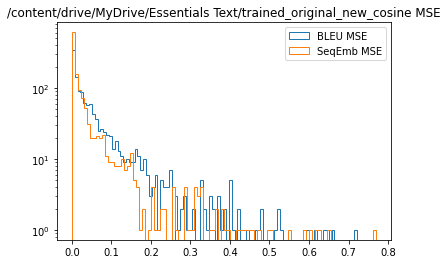

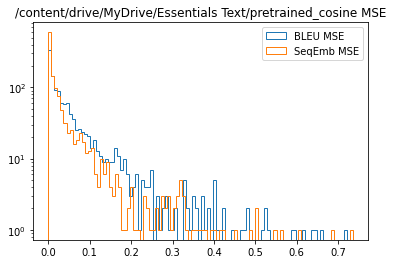

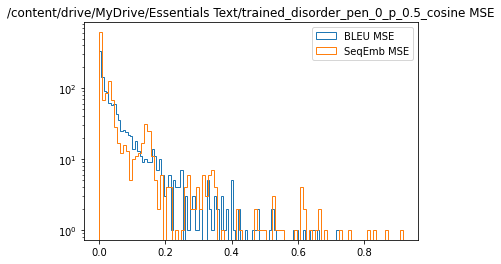

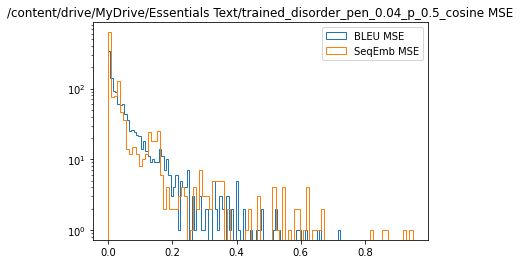

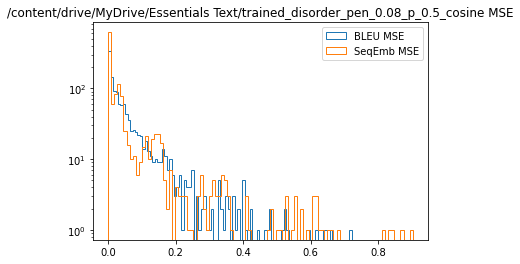

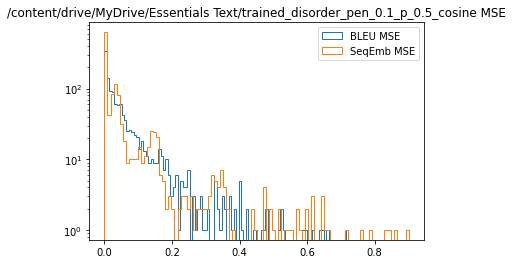

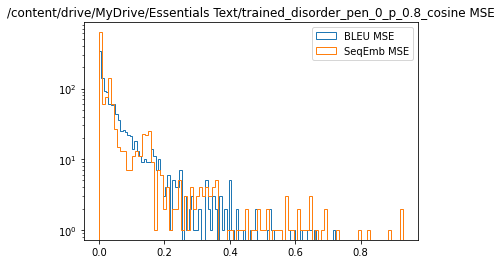

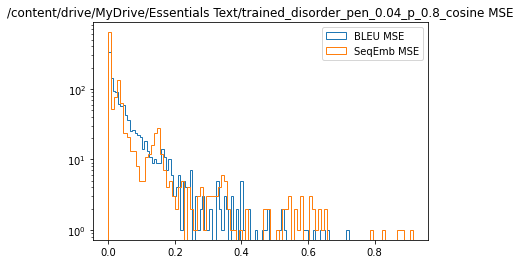

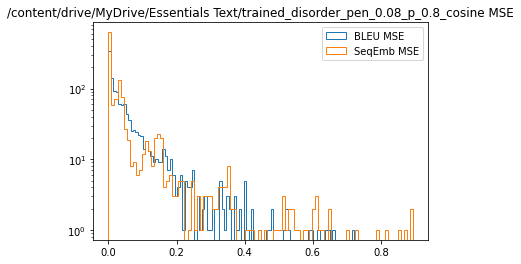

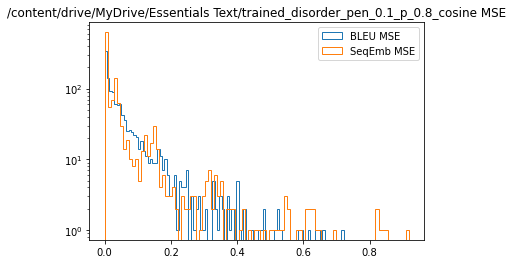

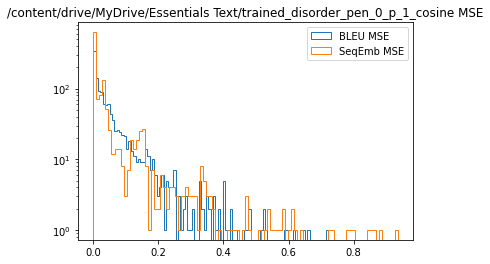

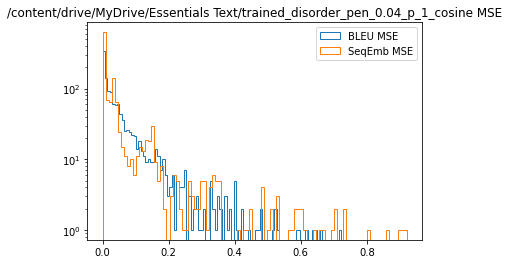

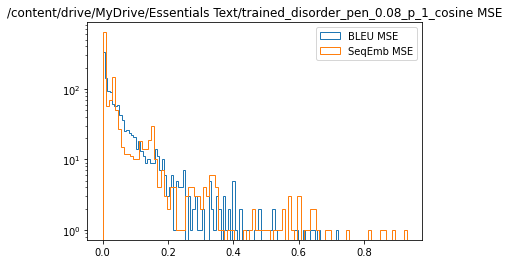

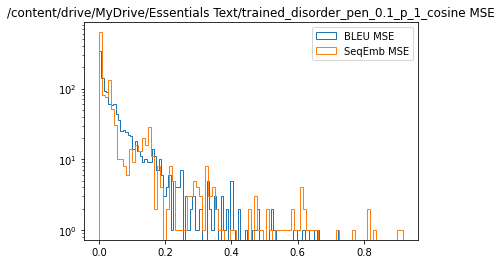

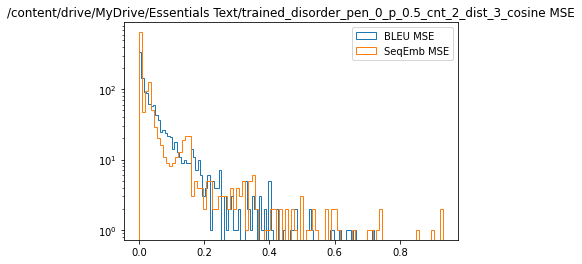

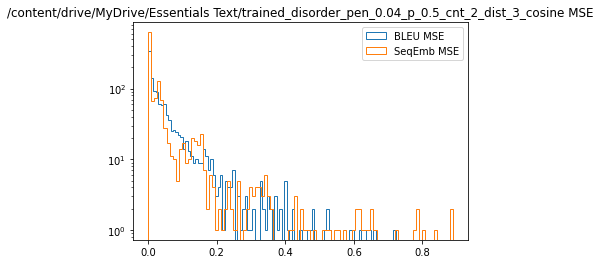

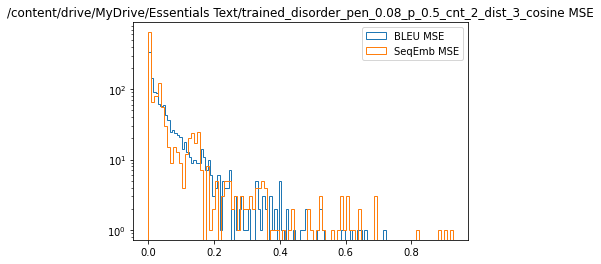

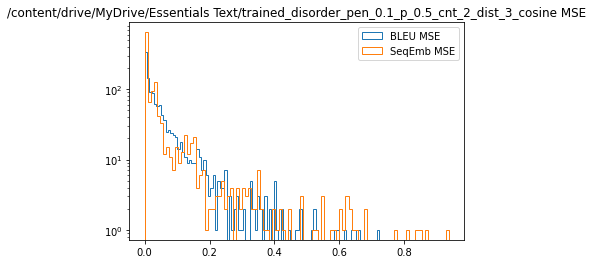

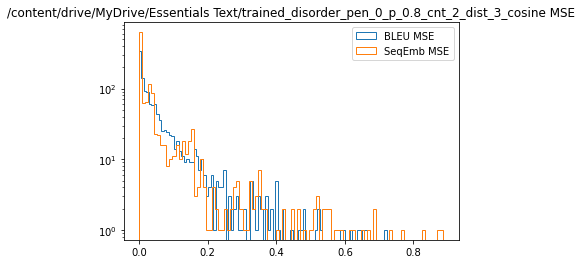

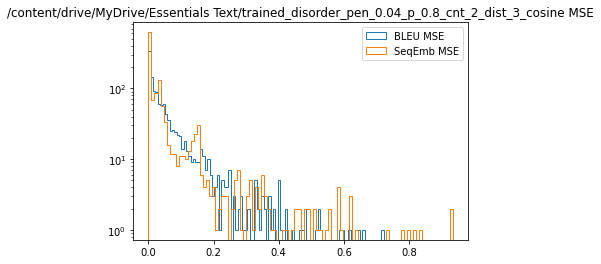

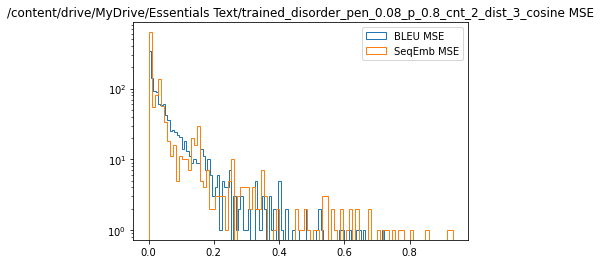

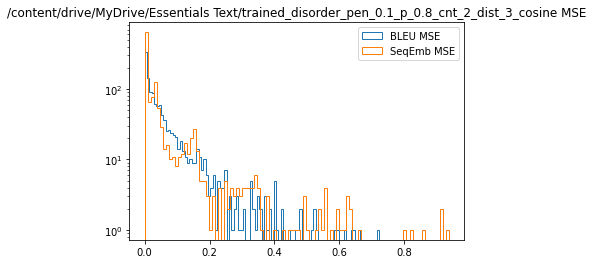

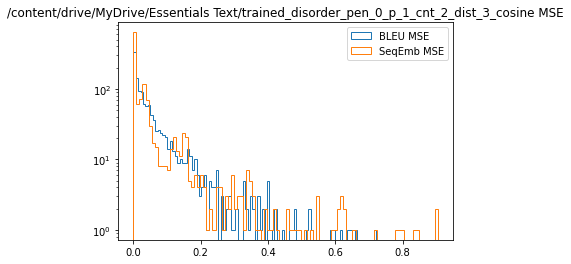

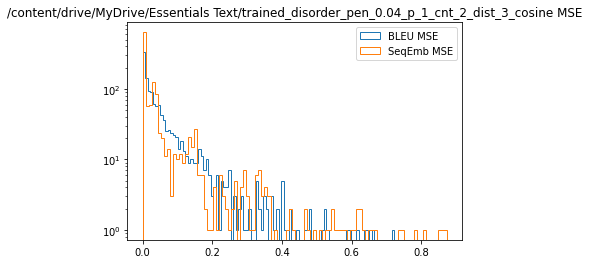

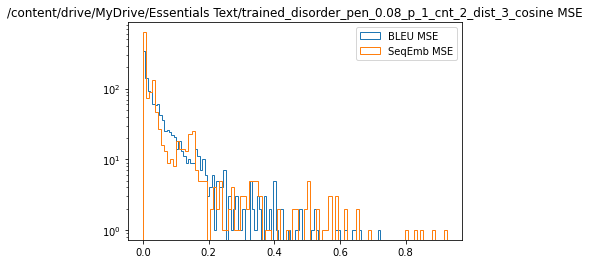

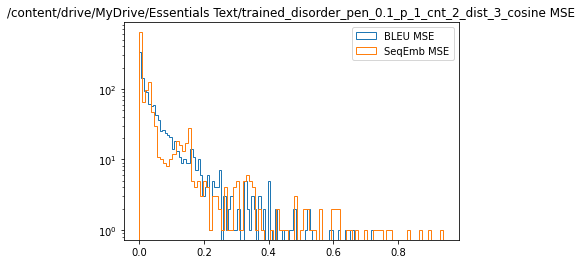

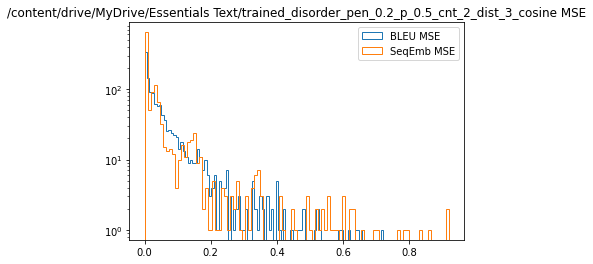

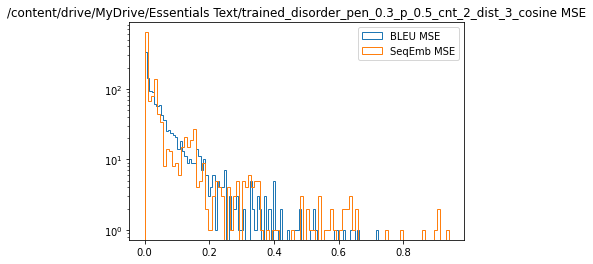

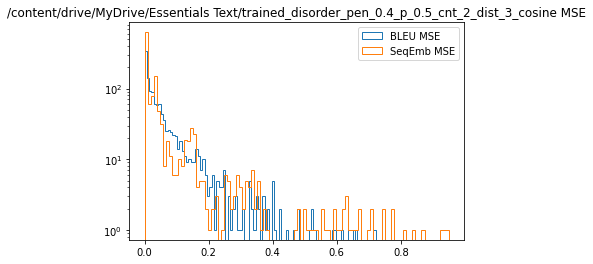

In [26]:
data_base = "/content/drive/MyDrive/Essentials Text/"

exp_params = [     
    {
        "only_plot":True,
        "train":False,
        "data_base": data_base,
        "model_name": "trained_original_new",
        "similarity": "cosine",
        "disorder_percentage": 0, 
        "disorder_cnt": 0, 
        "disorder_swap_dist": 0, 
        "label_penality": 0,
    },
    
    { 
        "only_plot":True,
        "train":False,
        "data_base": data_base,
        "model_name": "pretrained",
        "similarity": "cosine",
        "disorder_percentage": 0, 
        "disorder_cnt": 0, 
        "disorder_swap_dist": 0, 
        "label_penality": 0,
    }
    ]
# "trained_disorder_pen_{label_penality}_p_{disorder_percentage}  cnt =3 ,dist =1 
for disorder_percentage in [0.5, 0.8, 1]:
    for label_penality in [0, 0.04, 0.08, 0.1]:
        exp_params.append({
            "only_plot":True,
            "train":False,
            "data_base": data_base,
            "model_name": f"trained_disorder_pen_{label_penality}_p_{disorder_percentage}",
            "similarity": "cosine",
            "disorder_percentage": disorder_percentage, 
            "disorder_cnt": 2, 
            "disorder_swap_dist": 3, 
            "label_penality": label_penality,
        })

for disorder_percentage in [0.5, 0.8, 1]:
    for label_penality in [0, 0.04, 0.08, 0.1]:
        exp_params.append({
            "only_plot":True,
            "train":False,
            "data_base": data_base,
            "model_name": f"trained_disorder_pen_{label_penality}_p_{disorder_percentage}_cnt_2_dist_3",
            "similarity": "cosine",
            "disorder_percentage": disorder_percentage, 
            "disorder_cnt": 2, 
            "disorder_swap_dist": 3, 
            "label_penality": label_penality,
        })

for disorder_percentage in [0.5]:
    for label_penality in [0.2, 0.3, 0.4]:
        exp_params.append({
            "only_plot":True,
            "train":False,
            "data_base": data_base,
            "model_name": f"trained_disorder_pen_{label_penality}_p_{disorder_percentage}_cnt_2_dist_3",
            "similarity": "cosine",
            "disorder_percentage": disorder_percentage, 
            "disorder_cnt": 2, 
            "disorder_swap_dist": 3, 
            "label_penality": label_penality,
        })


for param in exp_params:
    run(**param)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning

result /content/drive/MyDrive/Essentials Text/trained_original_new_cosine
native cnt: 0.6309148669242859
MSE cus: 0.03850220888853073
MSE bleu: 0.06151188164949417
MAE cus: 0.13625003397464752
MAE bleu: 0.19591693580150604
result /content/drive/MyDrive/Essentials Text/trained_disorder_pen_0.1_p_1_cosine
native cnt: 0.5417981147766113
MSE cus: 0.056993287056684494
MSE bleu: 0.06151188164949417
MAE cus: 0.1562069207429886
MAE bleu: 0.19591693580150604


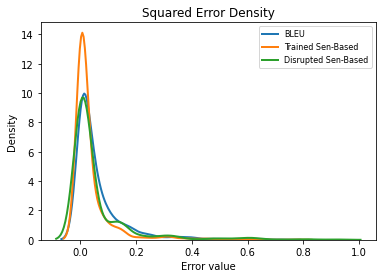

In [85]:
bleu_hist_data, trained_hist_data = analysis_error(data_base + "trained_original_new_cosine")
_   , dis_hist_data = analysis_error(data_base+"trained_disorder_pen_0.1_p_1_cosine")
bleu_hist_data = bleu_hist_data.tolist()
trained_hist_data = trained_hist_data.tolist()
dis_hist_data = dis_hist_data.tolist()


import seaborn as sns


sns.distplot(bleu_hist_data, hist = False, kde = True,
                 kde_kws = {'linewidth': 2},
                 label = "BLEU")

sns.distplot(trained_hist_data, hist = False, kde = True,
                 kde_kws = {'linewidth': 2},
                 label = "Trained Sen-Based")
    
sns.distplot(dis_hist_data, hist = False, kde = True,
                 kde_kws = {'linewidth': 2},
                 label = "Disrupted Sen-Based")
    
plt.legend(prop={'size': 8})
plt.title('Squared Error Density'); 
plt.xlabel('Error value')
plt.ylabel('Density');
plt.savefig(data_base + "3_in_1_sen_density.png")

### check model

In [70]:
test_model = load_model("trained_original")

idxx = 45
seq_t = sys[idxx]
ref_t = ref[idxx]
mqm_t = mqm_data[idxx]
bleu_t = bleu_data[idxx]
dis = random_disorder_seq(sys[45],0, 2, 1, 0.1, 1)[0]


strs, emb= seq_embeddings(test_model, [seq_t, dis, ref_t])

print(f"ori_sim {similarity_wrapper('cosine', emb[0], emb[2])}")

print(f"dis_sim {similarity_wrapper('cosine', emb[1], emb[2])}")

print(f"word_sim {similarity(seq_t, ref_t)}")
print(f"sys {seq_t}") 
print(f"ref {ref_t}") 
print(f"bleu {bleu_t}") 
mqm_t

ori_sim tensor([0.9703], device='cuda:0')
dis_sim tensor([0.9669], device='cuda:0')
word_sim 0.708590517115306
sys As is customary, the SONA will be broadcast live to the Philippine nation in real time.
ref Traditionally, the SONA will be broadcast live to the Philippines in real time.
bleu 0.7872440873741523


0.6000000238418579